# Прогнозирование временных рядов с помощью модели состояние-наблюдение

Сначала импортируем библиотеки:

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

from statsmodels.graphics.api import qqplot
from pandas.tools.plotting import autocorrelation_plot
from pandas.tseries.offsets import CustomBusinessDay

import statsmodels
import statsmodels.stats.api as sms
from statsmodels.sandbox.regression.predstd import wls_prediction_std

Оформим шаги для прогнозирования и построения графиков в функцию:

In [2]:
def plot(res_model, title):
    predict = res_model.get_prediction(start='2014-11-01', 
                                       end='2015-02-20')
    forecast = res_model.get_forecast('2015-03-20')

    fig, ax = plt.subplots(figsize=(12,6))

    dta.ix['2014-11-01':].plot(ax=ax, style='k', 
                               label='Observations')
    predict.predicted_mean.plot(ax=ax, 
                                label='One-step-ahead Prediction')

    predict_ci = predict.conf_int(alpha=0.05)
    ax.fill_between(predict_ci.index[2:], predict_ci.iloc[2:, 0], 
                    predict_ci.iloc[2:, 1], alpha=0.1, 
                    label='95% confidence interval')

    forecast.predicted_mean.plot(ax=ax, style='--', 
                                 label='Forecast')
    forecast_ci = forecast.conf_int()
    ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], 
                    forecast_ci.iloc[:, 1], alpha=0.1, 
                    label='95% confidence interval')

    legend = ax.legend(loc='lower left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    title = title + ' results'
    ax.set_title(title)


Считываем данные:

In [3]:
df = pd.read_csv('Term Paper/train.csv')
df.index = pd.to_datetime(df.Date)
df.head()

/Users/ola/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
Date                                                                      
2015-07-31      1          5  2015-07-31   5263        555     1      1   
2015-07-31      2          5  2015-07-31   6064        625     1      1   
2015-07-31      3          5  2015-07-31   8314        821     1      1   
2015-07-31      4          5  2015-07-31  13995       1498     1      1   
2015-07-31      5          5  2015-07-31   4822        559     1      1   

           StateHoliday  SchoolHoliday  
Date                                    
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1

Видим, что данные сгруппированы по дням, для начала попробуем посмотреть на продажи одного магазина.

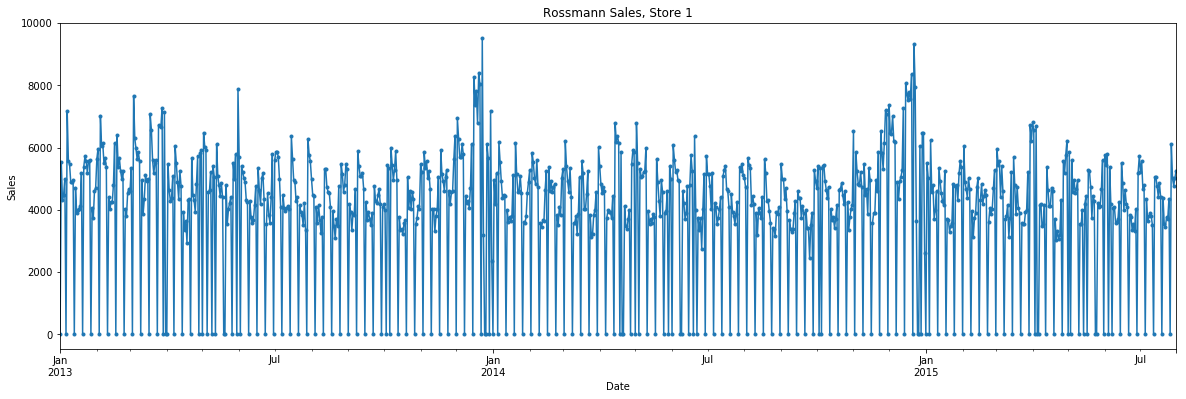

In [4]:
df[df.Store==1].sort_values('Date').Sales.plot(marker='.', 
                                                   figsize=(20,6))
plt.title('Rossmann Sales, Store 1')
plt.ylabel('Sales')

Из-за выходных и праздников, когда магазин закрыт и продаж нет, график выглядит очень зашумлённым. Более того, эти выбросы сильно влияют на результаты модолей, описанных мной далее, делают их менее наглядными. По этой причине я решила на время убрать нулевые значения из ряда, тем более, что они подчиняются понятному паттерну и их легко можно будет восстановить. Однако убрав их, я всё же не стану сохранять исходную последовательность дат, поскольку мне важны качественные результаты моделей, а не сами предсказанные значения. Работать же с исходной последовательностью дат не получается из-за того, что библиотека `statsmodels` не может давать прогноз на будущее для "необычных" дат: функция `get_forecast` не берёт аргумент `freq`, задающий периодичность дней, которая здесь нестандартна: исключается каждое седьмое значение (те, что соответствуют воскресеньям), а также праздники.

In [5]:
# создаём новый объект Series, где значениями будут продажи первого магазина

dta = df[(df.Store==1) 
           & (df.Open==1)].sort_values('Date').Sales # оставили только первый магазин и отсортировали
dta.index = pd.date_range(start='2013-01-01', periods=dta.shape[0])
dta.head()

2013-01-01    5530
2013-01-02    4327
2013-01-03    4486
2013-01-04    4997
2013-01-05    7176
Freq: D, Name: Sales, dtype: int64

Теперь посмотрим, что получилось:

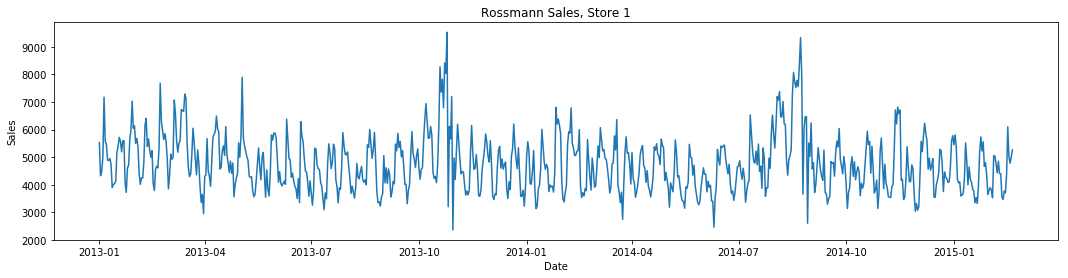

In [6]:
fig, ax = plt.subplots(figsize=(18,4))

ax.plot(dta)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Rossmann Sales, Store 1')

Проверяем ряд на стационарность с помощью расширенного теста Дики-Фуллера, в котором основная гипотеза формулируется как "ряд нестационарен".

In [7]:
result = sm.tsa.stattools.adfuller(dta)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.399623
p-value: 0.000003
Critical Values:
	1%: -3.439
	10%: -2.569
	5%: -2.865


Получили очень маленькое p-value, так что на любом разумном уровне значимости ряд можно считать стационарным. 

Перейдём к построению моделей!

## Model 1: irregular

Самая простая модель для временных рядов: в ней нет ни тренда, ни сезонности, а наблюдения считаются независимыми одинаково распределёнными случайными величинами с нулевым математическим ожиданием:

$$y_t = \varepsilon_t$$ 
$$\varepsilon_t \text{ iid: } \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$


Тогда в силу независимости случайных величин $Y_1, Y_2, ...$ для любого положительного целого числа $n$ и  $y_1,..., y_n$:

$$ P[Y_1 \leq y_1, ..., Y_n \leq y_n] = P[Y_1 \leq y_1] \cdot ... \cdot P[Y_n \leq y_n] = F(y_1) \cdot ... \cdot F(y_n), $$

где $F(\cdot)$ – функция распределеия случайных величин $Y_1, Y_2,...$. Поскольку в модели предполагается, что наблюдения независимы, то для всех $h > 1$ и для всех $y_1,..., y_n$:

$$ P[Y_{n+h} \leq y \mid Y_1=y_1, ... Y_n = y_n] = P[Y_{n+h} \leq y] $$

Другими словами, предыдущие наблюдения не несут никакой информации о следующем наблюдении $Y_{n+h}$. При известных значениях $Y_1, Y_2, ...$ функция $f$, которая минимизирует среднеквадратичную ошибку $E[(Y_{n+h}-f(Y_1, ...,Y_n)^2]$ равна нулю, покажем:

$E[(Y_{n+h}-f(Y_1, ...,Y_n)^2] = E[Y_{n+h}^2 - 2 \cdot Y_{n+h} \cdot f(Y_1, ...,Y_n) +  f(Y_1, ...,Y_n)^2] = E[Y_{n+h}^2] - 2 \cdot f(Y_1, ...,Y_n) \cdot E[Y_{n+h}] + f(Y_1, ...,Y_n)^2  \to min_f $

Так как $Y_{n+h} \sim \mathcal{N}(0, \sigma^2_\varepsilon) $, то $E[Y_{n+h}] = 0$ и задача сводится к минимизации следующей функции:

$E[Y_{n+h}^2]+ f(Y_1, ...,Y_n)^2  \to min  $, а её минимум достигается, очевидно, при $f(Y_1, ...,Y_n)=0$.

In [8]:
model_1 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level=False, trend=False, 
                                                                     seasonal=None, cycle=False, autoregressive=None, 
                                                                     exog=None, irregular=True, stohastic_level=False,
                                                                     stohastic_trend=False, stohastic_seasonal=False, 
                                                                     stohastic_cycle=False, damped_cycle=False,
                                                                     cycle_period_bounds=None)

In [9]:
res_model_1 = model_1.fit()
res_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                      irregular   Log Likelihood               -7738.959
Date:                Thu, 22 Jun 2017   AIC                          15479.918
Time:                        11:19:58   BIC                          15484.578
Sample:                    01-01-2013   HQIC                         15481.710
                         - 02-20-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.302e+07   3.53e+06      6.515      0.000    1.61e+07    2.99e+07
===================================================================================
Ljung-Box (Q):                     1255.50   Jarque-Bera (JB):               190.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.93
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

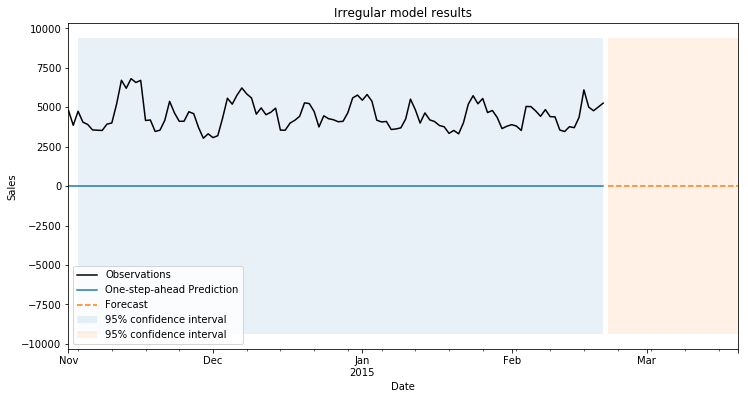

In [10]:
plot(res_model_1, 'Irregular model')

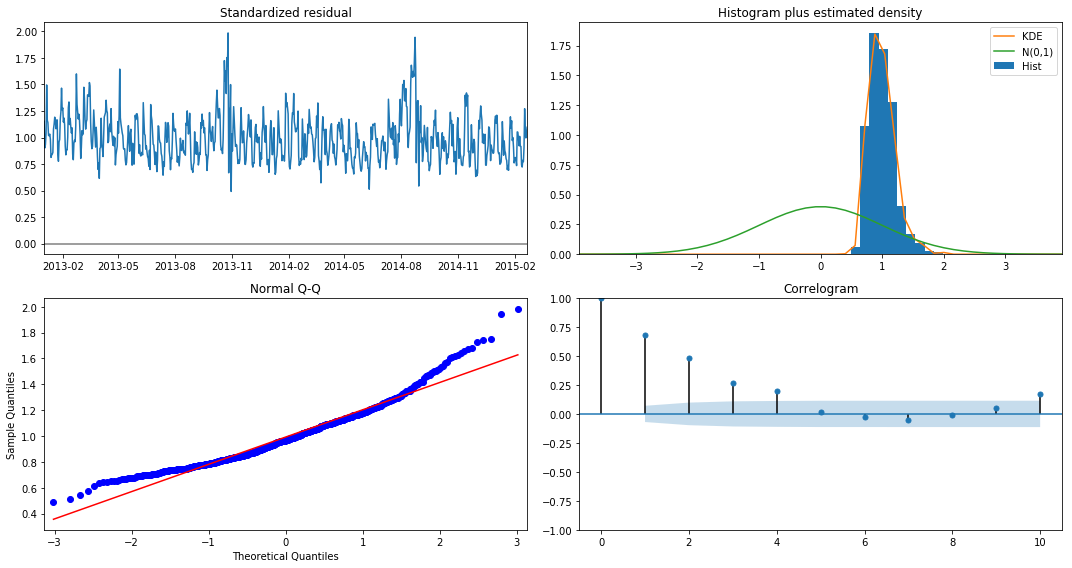

In [11]:
res_model_1.plot_diagnostics(figsize=(15,8))
plt.tight_layout()

## Model 2: determenistic constant

Ещё одна простая модель, в которой наблюдения предполагаются независимыми и одинаково распределёнными случайными величинами и моделируются константой:

$$y_t = \mu + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon) $$

Сама константа получается из задачи минимизации среднеквадратичной ошибки. Как и в предыдущей модели, наблюдения независимы, поэтому предсказываемое значение не зависит от предыдущих и задачу можно записать так:

$$ MSE = E[(Y_{n+h} - c)^2] = E[Y_{n+h}^2 - 2 \cdot c \cdot Y_{n+h} + c^2] = E(Y_{n+h}^2) - 2 \cdot c \cdot E(Y_{n+h}) + c^2 = E(Y_{n+h}^2) - 2 \cdot c \cdot \mu + c^2 \to min $$

$$ \frac{\partial MSE}{\partial c} = -2 \cdot \mu + 2 \cdot c \Rightarrow c = \mu $$

Получили, что искомая константа – это математическое ожидание наблюдений. Но поскольку нам неизвестно точное распределение наблюдений, предсказываемые значения должно быть близки к выборочному среднему, потому что наблюдений много. Проверим:

In [12]:
model_2 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level=True,
                                                                   trend=False, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=False,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

In [13]:
res_model_2 = model_2.fit()
res_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Unobserved Components Results                           
==================================================================================
Dep. Variable:                      Sales   No. Observations:                  781
Model:             deterministic constant   Log Likelihood               -6510.928
Date:                    Thu, 22 Jun 2017   AIC                          13023.857
Time:                            11:20:03   BIC                          13028.517
Sample:                        01-01-2013   HQIC                         13025.649
                             - 02-20-2015                                         
Covariance Type:                      opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.012e+06   4.01e+04     25.220      0.000    9.33e+05    1.09e+06
===================================================================================
Ljung-Box (Q):                     1240.30   Jarque-Bera (JB):               198.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.95
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
print('Выборочное среднее: ', np.mean(dta))
print('Значение прогноза: ' , 
      res_model_2.predict(start='2015-02-20').values)

Выборочное среднее:  4759.096030729834
Значение прогноза:  [ 4752.28614457]


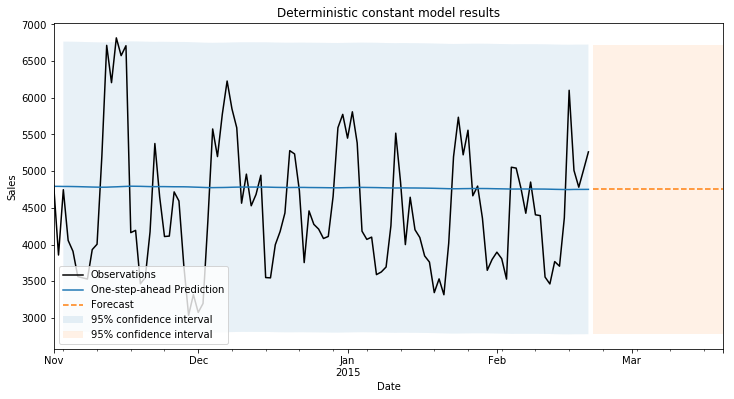

In [15]:
plot(res_model_2, title='Deterministic constant model')

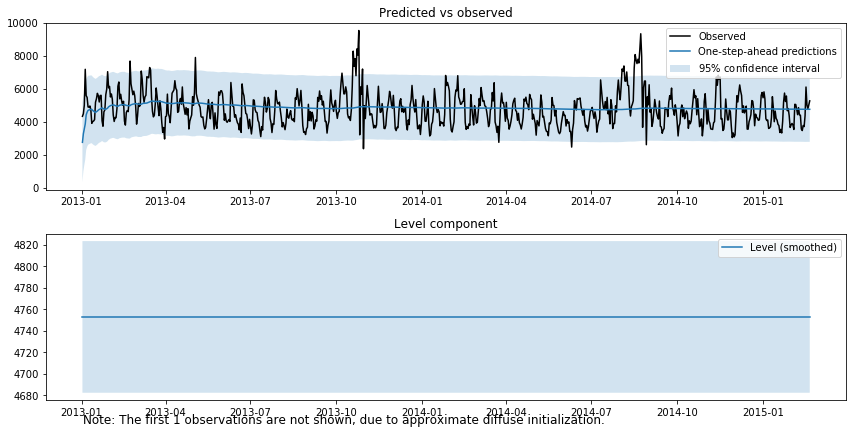

In [16]:
res_model_2.plot_components(figsize=(12,6))
plt.tight_layout()

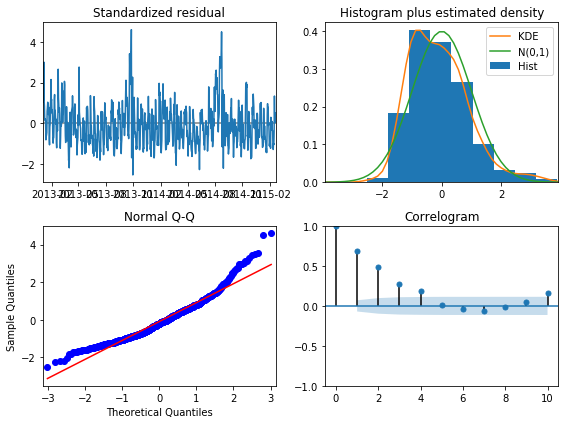

In [17]:
res_model_2.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

## Model 3: local level

Модель local level, в отличие от предыдущих, показывает структуру моделей наблюдение–состояние: ненаблюдаемые компоненты $\mu_1, ..., \mu_n$, которые и назавают состояниями, отражают изменения всей системы, а $y_1, ... y_n$ – наблюдения, связанные с $\mu_t$.

$$ y_t = \mu_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon) $$

$$ \mu_{t+1} = \mu_{t} + \eta_t, \eta_t \sim \mathcal{N}(0, \sigma_\eta^2)$$

$$ \mu_1 \sim \mathcal{N}(a_1, P_1) $$

В этой модели распределения случайных величин $y_t$ и $\mu_t$ зависят от врмени $t$, и дополнително предполагается, что в начальный момент времени $ \mu_1 \sim \mathcal{N}(a_1, P_1) $, где $a_1, P_1$, а также $ \sigma^2_\varepsilon,\sigma_\eta^2 $ известны.

Заметим, что при $\sigma_\eta^2 = 0$ получается константная модель (Deterministic constant), а при $\sigma^2_\varepsilon=0$ – Random Walk.

Что касается прогнозирования, то значения ненаблюдаемой переменной $\mu_t$ могут быть найдены с помощью фильтра Калмана, который позволяет посчитать математическое ожидание и дисперсию ненаблюдаемого состояния с учётом наблюдений. Фильтр Калмана – это рекурсивный алгоритм, и текущеая оценка параметров обновляется, как только появляется новое наблюдение. По этой причине и необходимо задать начальные значения $a_1, P_1$.

In [18]:
model_3 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='llevel',
                                                                   trend=False, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [19]:
res_model_3 = model_3.fit()
res_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                    local level   Log Likelihood               -6311.565
Date:                Thu, 22 Jun 2017   AIC                          12627.129
Time:                        11:20:11   BIC                          12636.450
Sample:                    01-01-2013   HQIC                         12630.714
                         - 02-20-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.312e+05   1.61e+04      8.167      0.000    9.97e+04    1.63e+05
sigma2.level      3.906e+05   3.08e+04     12.663      0.000     3.3e+05    4.51e+05
===================================================================================
Ljung-Box (Q):                      314.51   Jarque-Bera (JB):              1878.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.72
Prob(H) (two-sided):                  0.12   Kurtosis:                        10.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

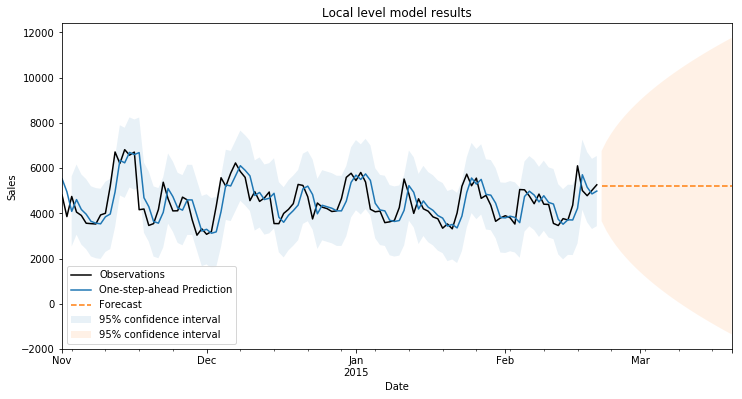

In [20]:
plot(res_model_3, 'Local level model')

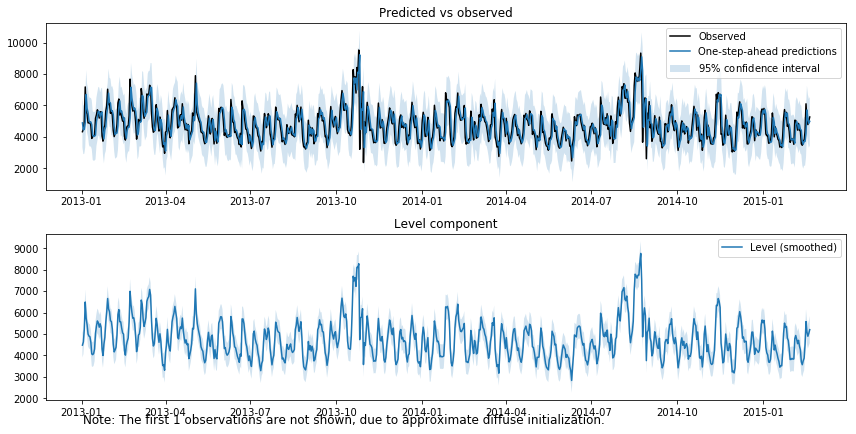

In [21]:
res_model_3.plot_components(figsize=(12,6))
plt.tight_layout()

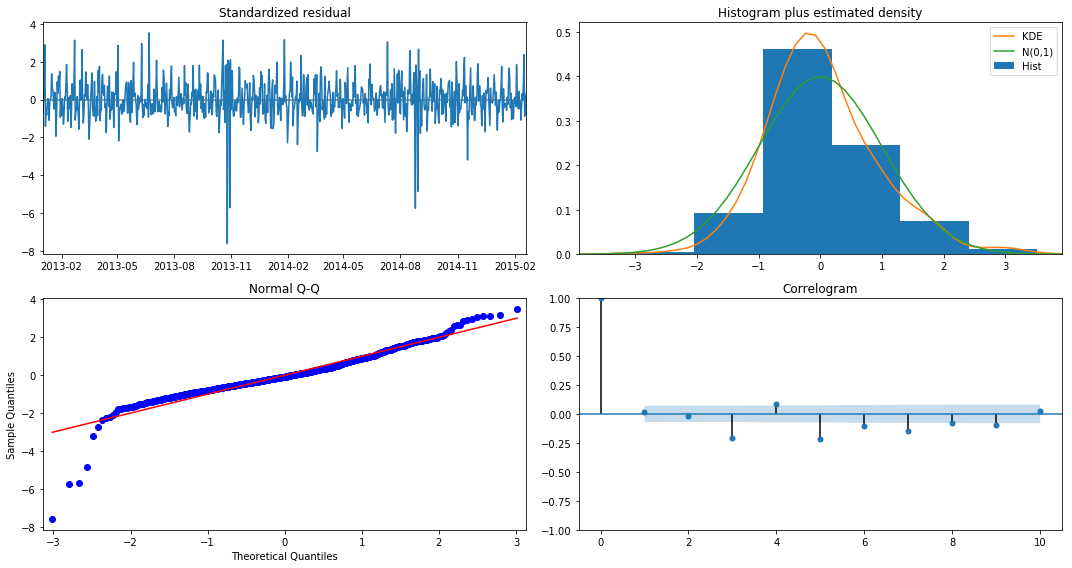

In [22]:
res_model_3.plot_diagnostics(figsize=(15,8))
plt.tight_layout()

## Model 4: random walk

В модели случайного блуждания каждое следующее значение предполагается равным сумме предыдущего и ошибки.

$$y_t = \mu_t$$

$$\mu_t = \mu_{t-1} + \eta_t , \eta_t \sim \mathcal{N}(0, \sigma_\eta^2) $$

При прогнозе на известных наблюдениях на один шаг вперёд получится этот же исходный ряд, но с лагом в один период, а прогнозирование на большее количество шагов вперёд будет равно последнему известному значению. Чтобы доказать это, нужно взять условное математическое ожидание от прогнозируемого значения при всех известных предыдущих значениях. Для $\mu_{t+k}$ и для любого $k ~\in ~\mathbb{N}$ уравнение ненаблюдаемой компоненты можно привести к виду $\mu_{t+k} = \mu_{t} + \sum_{i=2}^{k+1} \eta_{i}$, последовательно подставляя выражения для $\mu_{i}$ до первого известного. Тогда прогноз будет таким:

$$
\hat{\mu}_{t+k} = E(\mu_{t} + \sum_{i=2}^{k+1} \eta_{i} \mid \mu_{t}, \mu_{t-1}...) = E(\mu_{t} \mid \mu_{t}, \mu_{t-1}...) =\mu_{t}
$$
что и есть последнее известное значение.

In [23]:
model_4 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='rwalk',
                                                                   trend=False, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=False,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

In [24]:
res_model_4 = model_4.fit()
res_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                    random walk   Log Likelihood               -6326.664
Date:                Thu, 22 Jun 2017   AIC                          12655.328
Time:                        11:20:18   BIC                          12659.989
Sample:                    01-01-2013   HQIC                         12657.120
                         - 02-20-2015                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  6.453e+05   1.43e+04     44.970      0.000    6.17e+05    6.73e+05
===================================================================================
Ljung-Box (Q):                      249.21   Jarque-Bera (JB):              2275.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.76
Prob(H) (two-sided):                  0.09   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
print('Последнее наблюдение:\n', dta.tail(1))
print('Прогноз:\n', res_model_4.predict(start='2015-02-20', end='2015-02-25'))

Последнее наблюдение:
 2015-02-20    5263
Freq: D, Name: Sales, dtype: int64
Прогноз:
 2015-02-20    5020.0
2015-02-21    5263.0
2015-02-22    5263.0
2015-02-23    5263.0
2015-02-24    5263.0
2015-02-25    5263.0
Freq: D, dtype: float64


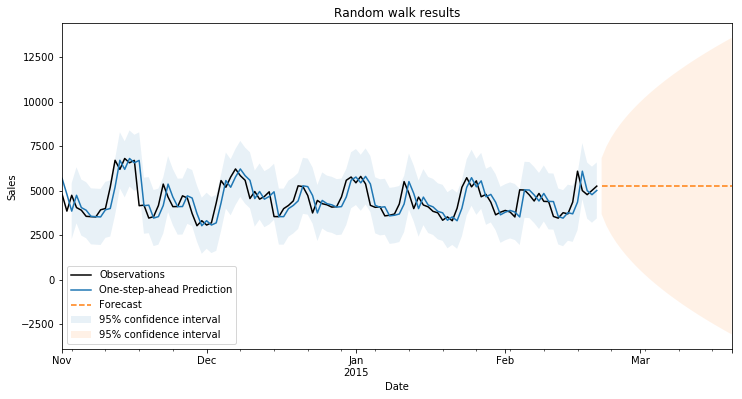

In [26]:
plot(res_model_4, 'Random walk')

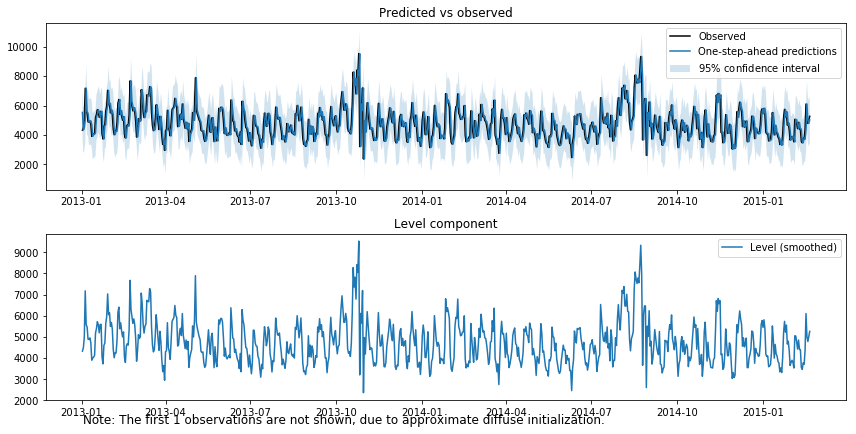

In [27]:
res_model_4.plot_components(figsize=(12, 6))
plt.tight_layout()

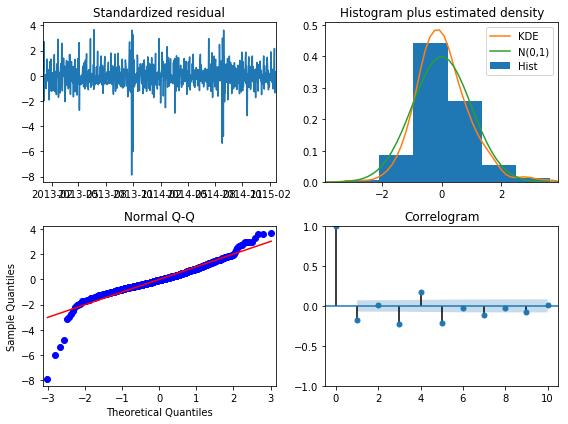

In [28]:
res_model_4.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

## Model 5: deterministic trend

В этой модели задаётся линейный тренд:

$$y_t = \mu_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$

$$\mu_t = \mu_{t-1} + \beta$$

И переменная, отвечающая за тренд, меняется на константу каждый период:

$y_t = \mu_{t-1} + \beta + \varepsilon_t $

$y_{t-1} = \mu_{t-2} + \beta + \varepsilon_{t-1} $

$E(y_t-y_{t-1}) = E[(\mu_{t-1} + \beta + \varepsilon_t) - (\mu_{t-2} + \beta + \varepsilon_{t-1})] = E(\mu_{t-1} + \varepsilon_t - \mu_{t-2} - \varepsilon_{t-1}) = E(\mu_{t-2} + \beta - \mu_{t-2}) + E(\varepsilon_t) - E( \varepsilon_{t-1}) = \beta$

In [29]:
model_5 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level=True,
                                                                   trend=True, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=False,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

In [30]:
res_model_5 = model_5.fit()
res_model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                   Sales   No. Observations:                  781
Model:             deterministic trend   Log Likelihood               -6506.633
Date:                 Thu, 22 Jun 2017   AIC                          13015.266
Time:                         11:20:26   BIC                          13019.927
Sample:                     01-01-2013   HQIC                         13017.059
                          - 02-20-2015                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.002e+06   3.62e+04     27.686      0.000    9.31e+05    1.07e+06
===================================================================================
Ljung-Box (Q):                     1238.29   Jarque-Bera (JB):               198.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Найдем коэффициент $\widehat \beta$ как разность двух соседних значений прогноза:

In [31]:
a = res_model_5.predict(start='2015-02-20', end = '2015-02-28')
a['2015-02-22'] - a['2015-02-21']

-0.46501909992275614

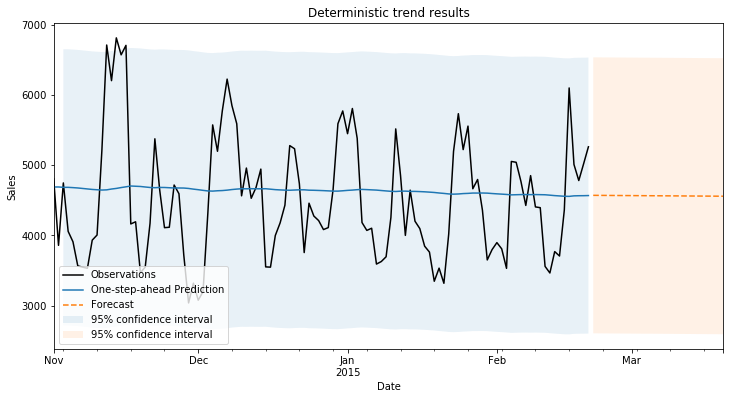

In [32]:
plot(res_model_5, 'Deterministic trend')

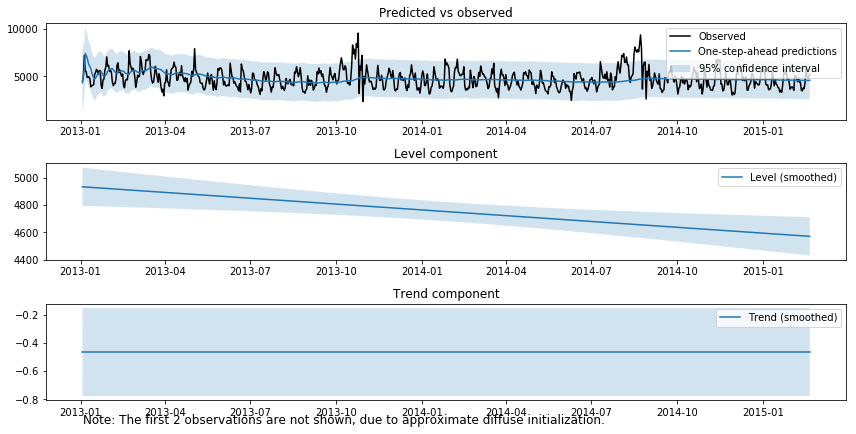

In [33]:
res_model_5.plot_components(figsize=(12,6))
plt.tight_layout()

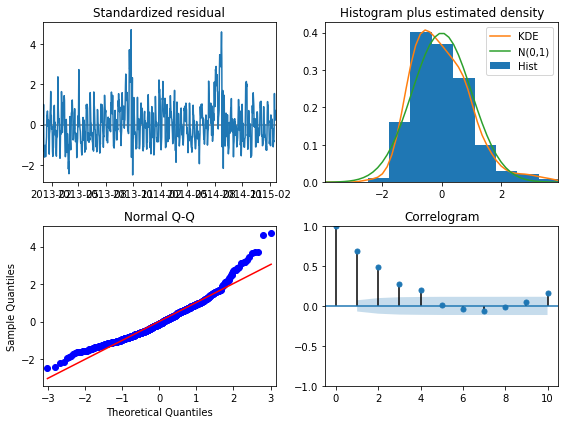

In [34]:
res_model_5.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

## Model 6: local linear deterministic trend

Отличие этой модели от предыдущей только в добавлении ошибки $\eta_t$ в тренд:

$$y_t = \mu_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$

$$\mu_t = \mu_{t-1} + \beta + \eta_t, \eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$$

Однако прогноз на известных данных больше напоминает результаты модели случайного блуждания: предыдущее изветсное значение + ошибка прогноза. А прогноз неизвестных значений отличается от предыдущего на константу $\beta$ – рассуждения такие же, как и в предыдущей модели. Тем не менее, из-за добавленной ошибки доверительный интервал будет расширяться со временем.

In [35]:
model_6 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='lldtrend',
                                                                   trend=True, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)
/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [36]:
res_model_6 = model_6.fit()
res_model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Unobserved Components Results                                
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  781
Model:             local linear deterministic trend   Log Likelihood               -6307.189
Date:                              Thu, 22 Jun 2017   AIC                          12618.379
Time:                                      11:20:41   BIC                          12627.700
Sample:                                  01-01-2013   HQIC                         12621.964
                                       - 02-20-2015                                         
Covariance Type:                                opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.292e+05   1.62e+04      7.994      0.000    9.76e+04    1.61e+05
sigma2.level      3.943e+05   3.13e+04     12.603      0.000    3.33e+05    4.56e+05
===================================================================================
Ljung-Box (Q):                      313.77   Jarque-Bera (JB):              1879.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.74
Prob(H) (two-sided):                  0.13   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Найдём параметр $\beta$:

In [37]:
a = res_model_6.predict(start='2015-02-20', end = '2015-02-28')
a['2015-02-22'] - a['2015-02-21']

0.51596698310277134

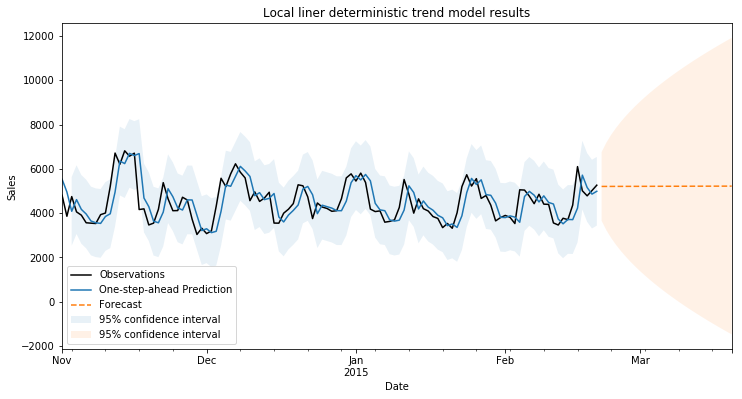

In [38]:
plot(res_model_6, 'Local liner deterministic trend model')

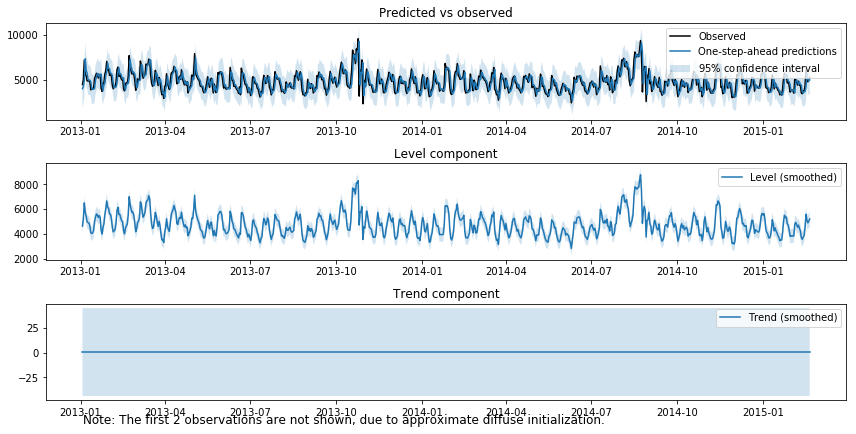

In [39]:
res_model_6.plot_components(figsize=(12,6))
plt.tight_layout()

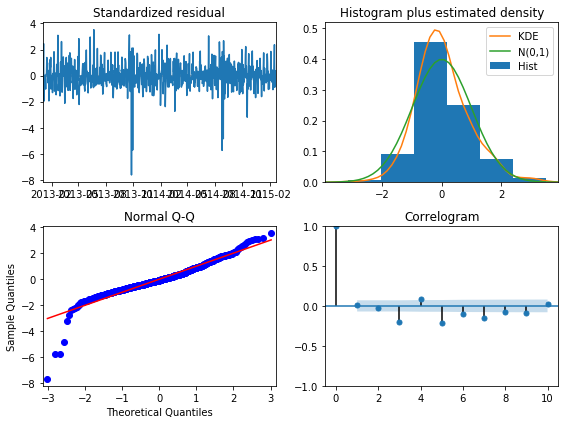

In [40]:
res_model_6.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

## Model 7: random walk with drift

Модель случайного блуждания со смещением записывается следующим образом:

$$y_t = \mu_t $$

$$\mu_t = \mu_{t-1} + \beta + \eta_t, \eta_t \sim \mathcal{N} (0, \sigma_\eta^2)$$

Если предположить начальное значение  $\mu_0 = a$ известным, то модель можно записать в виде: $\mu_t = a + t \cdot \beta + \sum_{j=0}^{t-1}\varepsilon_{t-j}$ . Найдём математическое ожидание и дисперсию:

$E(\mu_t) = E(y_t) = t \cdot \beta \to \infty, Var(\mu_t) = Var(y_t) = t\cdot \sigma_\varepsilon^2 \to \infty$, что объясняет вид графика с прогнозом.


In [41]:
model_7 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='rwdrift',
                                                                   trend=True, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=False,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [42]:
res_model_7 = model_7.fit()
res_model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Unobserved Components Results                           
==================================================================================
Dep. Variable:                      Sales   No. Observations:                  781
Model:             random walk with drift   Log Likelihood               -6321.694
Date:                    Thu, 22 Jun 2017   AIC                          12645.388
Time:                            11:20:46   BIC                          12650.048
Sample:                        01-01-2013   HQIC                         12647.180
                             - 02-20-2015                                         
Covariance Type:                      opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.level  6.461e+05   1.44e+04     44.910      0.000    6.18e+05    6.74e+05
===================================================================================
Ljung-Box (Q):                      249.25   Jarque-Bera (JB):              2293.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.78
Prob(H) (two-sided):                  0.09   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Константа $\widehat \beta$ равна:

In [43]:
b7 = res_model_7.predict(start='2015-02-20', end = '2015-02-28')
b7['2015-02-22'] - b7['2015-02-21']

-0.34202436575196771

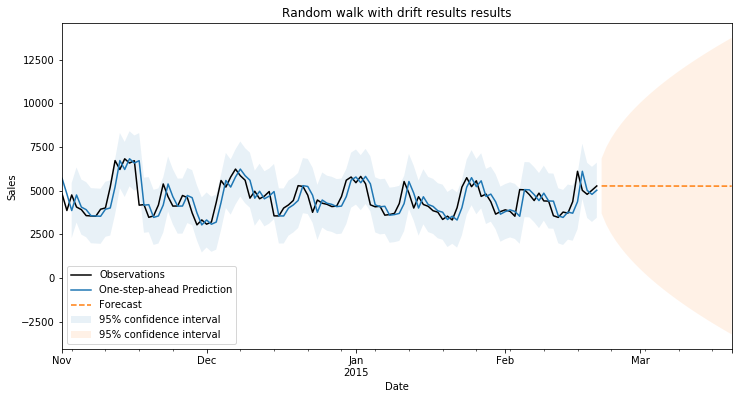

In [44]:
plot(res_model_7, 'Random walk with drift results')

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:1421: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


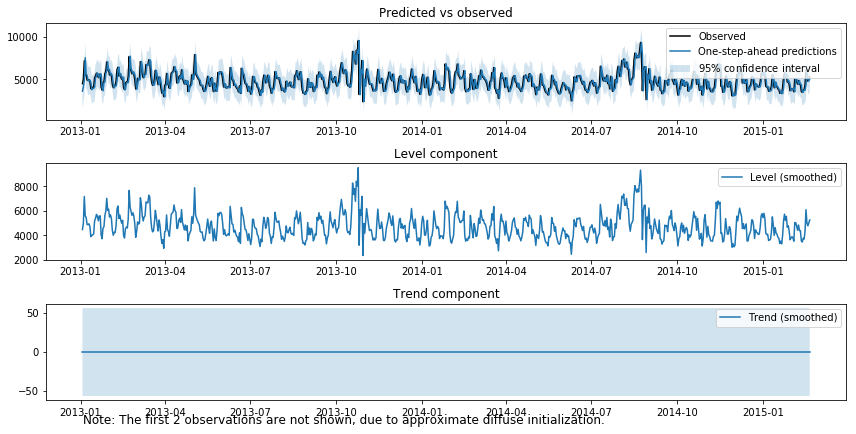

In [45]:
res_model_7.plot_components(figsize=(12,6))
plt.tight_layout()

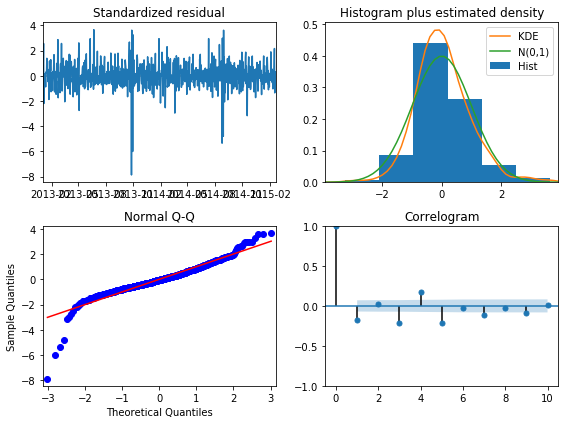

In [46]:
res_model_7.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

## Model 8: local linear trend

В этой модели добавляется ещё одна случайная компонента: наклон тренда $\beta$, значения которого моделируются случайным блужданием.

$$y_t = \mu_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$

$$\mu_t = \mu_{t-1} + \beta_{t-1} + \eta_t, \eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$$

$$\beta_t = \beta_{t-1} + \zeta_t, \zeta_t \sim \mathcal{N}(0, \sigma_\zeta^2)$$

Или она же, но в форме модели наблюдение-состояние:

$$ y_t = \begin{pmatrix} 1 & 0 \end{pmatrix} + \begin{pmatrix} \mu_t \\ \beta_t \end{pmatrix} +\varepsilon_t $$

$$ \begin{pmatrix} \mu_{t+1} \\ \beta_{t+1} \end{pmatrix} = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}  \begin{pmatrix} \mu_t \\ \beta_t \end{pmatrix} + \begin{pmatrix} \eta_t \\ \zeta_t \end{pmatrix}  $$

В модели остается только найти ковариационные матрицы:

$$ H_t = \begin{bmatrix} \sigma^2_\varepsilon \end{bmatrix}  $$

$$  Q_t = \begin{bmatrix} \sigma^2_\eta & 0 \\ 0 &  \sigma_\zeta^2 \end{bmatrix}   $$

In [47]:
model_8 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='lltrend',
                                                                   trend=True, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)
/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [48]:
res_model_8 = model_8.fit()
res_model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:             local linear trend   Log Likelihood               -6307.191
Date:                Thu, 22 Jun 2017   AIC                          12620.381
Time:                        11:20:59   BIC                          12634.363
Sample:                    01-01-2013   HQIC                         12625.759
                         - 02-20-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.296e+05   1.68e+04      7.739      0.000    9.68e+04    1.62e+05
sigma2.level      3.957e+05   3.15e+04     12.551      0.000    3.34e+05    4.57e+05
sigma2.trend         0.0004     63.802   6.26e-06      1.000    -125.048     125.049
===================================================================================
Ljung-Box (Q):                      313.71   Jarque-Bera (JB):              1879.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.74
Prob(H) (two-sided):                  0.13   Kurtosis:                        10.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

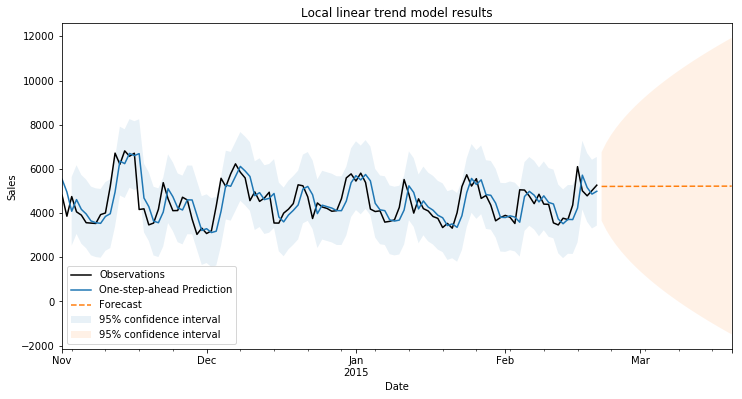

In [49]:
plot(res_model_8, 'Local linear trend model')

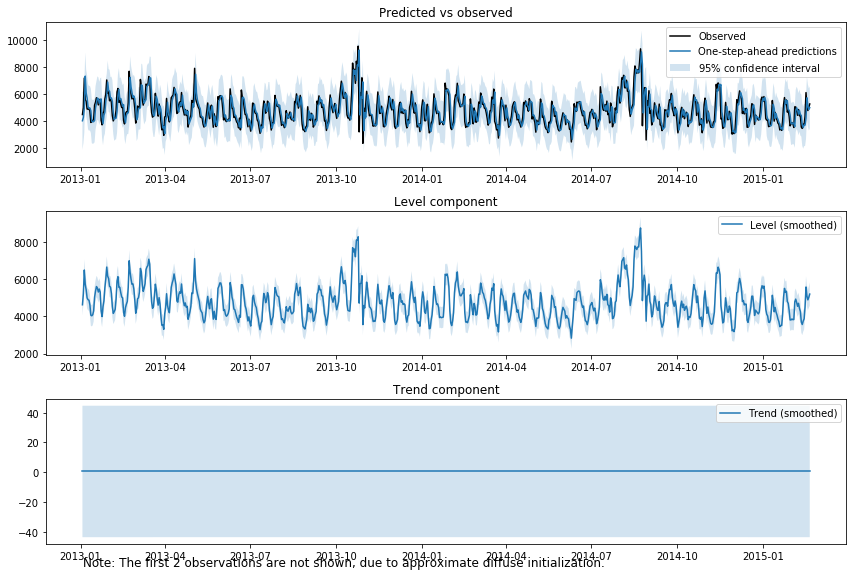

In [50]:
res_model_8.plot_components(figsize=(12, 8)) 
plt.tight_layout()

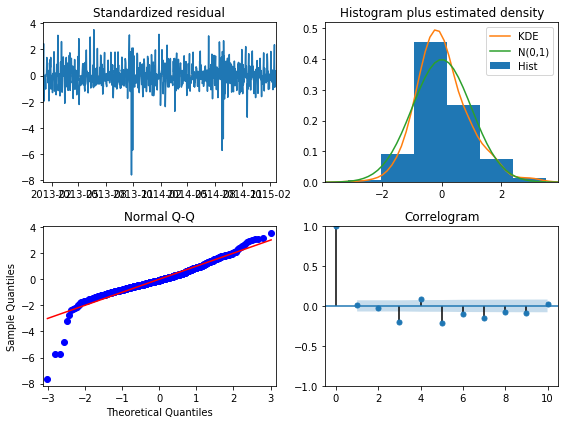

In [51]:
res_model_8.plot_diagnostics(figsize=(8,6))
plt.tight_layout()

## Model 9: smooth trend (integrated RW)

Отличие этой модели от предыдущей в том, что в уравнении, задающем тренд, отсутсвует компонента ошибки $\eta_t$, отчего модель получила название "сглаженный тренд".

$$y_t = \mu_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$

$$\mu_t = \mu_{t-1} + \beta_{t-1}$$

$$\beta_t = \beta_{t-1} + \zeta_t, \zeta_t \sim \mathcal{N}(0, \sigma_\zeta^2)$$

In [52]:
model_9 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='strend',
                                                                   trend=True, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)
/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [53]:
res_model_9 = model_9.fit()
res_model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                   smooth trend   Log Likelihood               -6422.152
Date:                Thu, 22 Jun 2017   AIC                          12848.304
Time:                        11:21:02   BIC                          12857.625
Sample:                    01-01-2013   HQIC                         12851.889
                         - 02-20-2015                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   2.98e+05   1.09e+04     27.230      0.000    2.77e+05    3.19e+05
sigma2.trend      8.248e+04   7917.166     10.418      0.000     6.7e+04     9.8e+04
===================================================================================
Ljung-Box (Q):                      388.96   Jarque-Bera (JB):               663.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -0.65
Prob(H) (two-sided):                  0.20   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

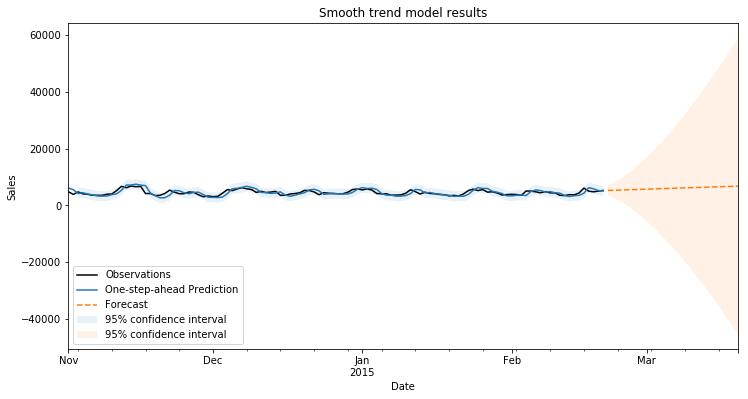

In [54]:
plot(res_model_9, 'Smooth trend model')

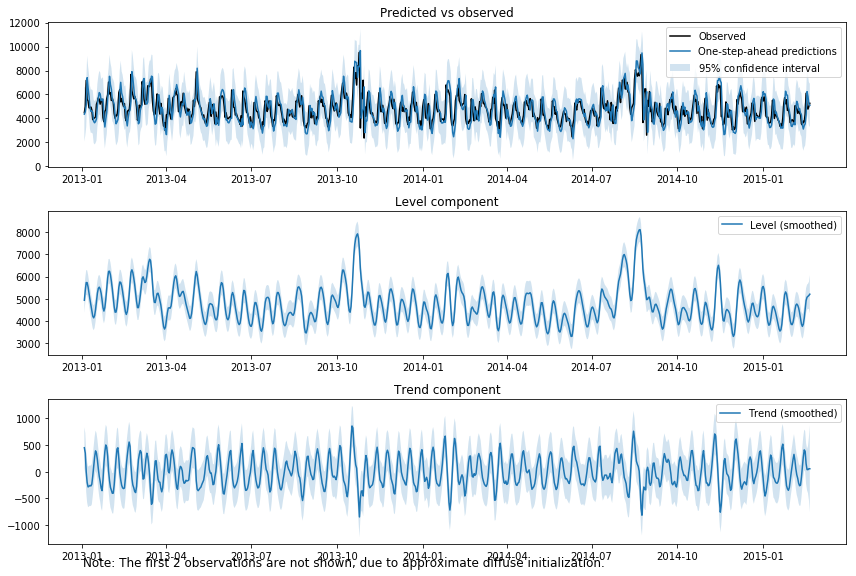

In [55]:
res_model_9.plot_components(figsize=(12, 8))
plt.tight_layout()

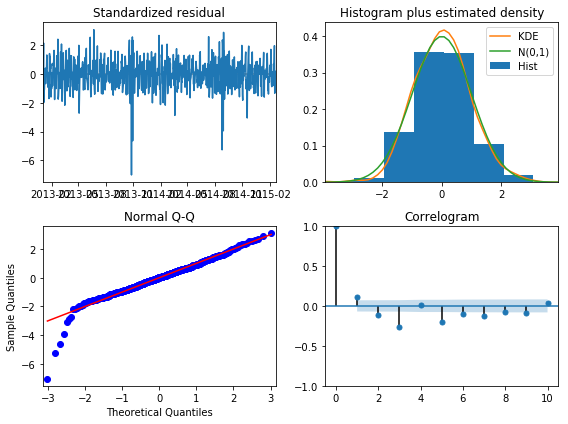

In [56]:
res_model_9.plot_diagnostics(figsize=(8, 6))
plt.tight_layout()

## Model 10: random trend

В этой модели отсутствует ещё одна переменная, та, что отвечает за погрешность наблюдения, – $\varepsilon_t$. В таком случе наблюдения моделируются предыдущими знчением тренда + шумовое значение из уравнения, задающего наклон.

$$y_t = \mu_t $$

$$\mu_t = \mu_{t-1} + \beta_{t-1}$$

$$\beta_t = \beta_{t-1} + \zeta_t, \zeta_t \sim \mathcal{N}(0, \sigma_\zeta^2)$$

In [57]:
model_10 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='rtrend',
                                                                   trend=True, seasonal=None,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=False,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [58]:
res_model_10 = model_10.fit()
res_model_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                   random trend   Log Likelihood               -6653.391
Date:                Thu, 22 Jun 2017   AIC                          13308.782
Time:                        11:21:07   BIC                          13313.443
Sample:                    01-01-2013   HQIC                         13310.575
                         - 02-20-2015                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sigma2.trend  1.529e+06   3.15e+04     48.574      0.000    1.47e+06    1.59e+06
===================================================================================
Ljung-Box (Q):                      540.69   Jarque-Bera (JB):              3275.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.30
Prob(H) (two-sided):                  0.03   Kurtosis:                        13.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

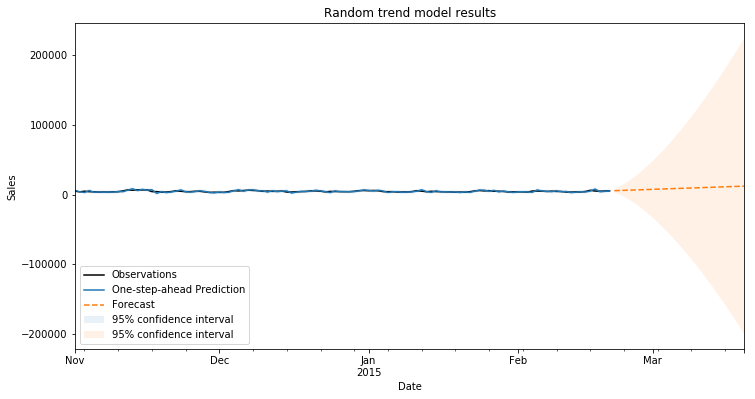

In [59]:
plot(res_model_10, 'Random trend model')

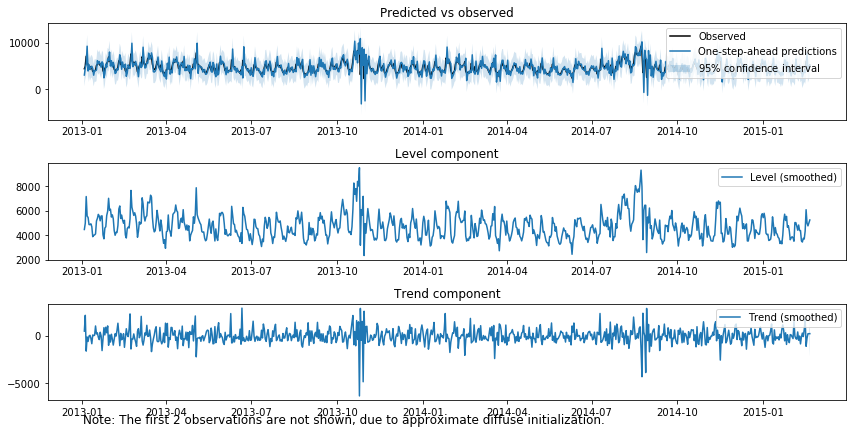

In [60]:
res_model_10.plot_components(figsize=(12, 6))
plt.tight_layout()

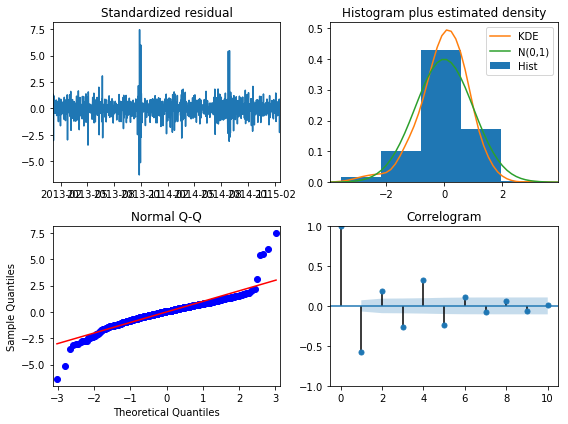

In [61]:
res_model_10.plot_diagnostics(figsize=(8, 6))
plt.tight_layout()

## Model 11: local linear trend + stohastic seasonal

В данной модели добавляется качественно новый компонент: сезонность, что позволяет учитывать колебания, повторяющися с некоторой фиксированной периодичностью.

$$y_t = \mu_t + \gamma_t + \varepsilon_t,  \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)$$

$$\mu_t = \mu_{t-1} + \beta_{t-1} + \eta_t, \eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$$

$$\beta_t = \beta_{t-1} + \zeta_t, \zeta_t \sim \mathcal{N}(0, \sigma_\zeta^2)$$

$$ \mu_1 \sim \mathcal{N}(a_1, P_1) $$

$$\gamma_t = - \sum_{j=1}^{s-1} \gamma_{t+1-j} + \omega_t, \omega_t \sim \mathcal{N}(0, \sigma_\omega^2), \text{s – периодичность}$$

По определению, детерминистическая сезонность с периодичностью $s$ – это последовательность чисел, которые повторяются каждые $s$ последовательных наблюдений: $\gamma_t = \gamma_{t-s}$. Более того, сумма их значений равна нулю через $s$ последовательных наблюдений, поскольку в данных за весь год сезонности нет: $\sum_{j=0}^{s-1}\gamma_{t-j}=0$. Таким образом, детерминистическая сезонность – это периодическая функция с нулевым средним значением, и при известных первых $s$ значениях (которые должны давать в сумме ноль!), можно получить все остальные значения с помощью рекурсии: $\gamma_t = - \sum_{j=1}^{s-1}\gamma_{t-j}$. А для того чтобы компонент мог изменяться с течением времени, необходимо добавить случайный шок $\omega_t$.

In [62]:
model_11 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=dta, level='lltrend',
                                                                   trend=True, seasonal=12,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=None, irregular=True,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=False,
                                                                   stohastic_seasonal=False,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)
/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [63]:
res_model_11 = model_11.fit()
res_model_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                         Sales   No. Observations:                  781
Model:                    local linear trend   Log Likelihood               -6223.626
                   + stochastic seasonal(12)   AIC                          12455.253
Date:                       Thu, 22 Jun 2017   BIC                          12473.895
Time:                               11:21:13   HQIC                         12462.422
Sample:                           01-01-2013                                         
                                - 02-20-2015                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.356e+05   1.71e+04      7.928      0.000    1.02e+05    1.69e+05
sigma2.level      3.359e+05   2.86e+04     11.765      0.000     2.8e+05    3.92e+05
sigma2.trend      1.819e-06     45.832   3.97e-08      1.000     -89.829      89.829
sigma2.seasonal   1014.1555    504.268      2.011      0.044      25.808    2002.503
===================================================================================
Ljung-Box (Q):                      242.62   Jarque-Bera (JB):              1516.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

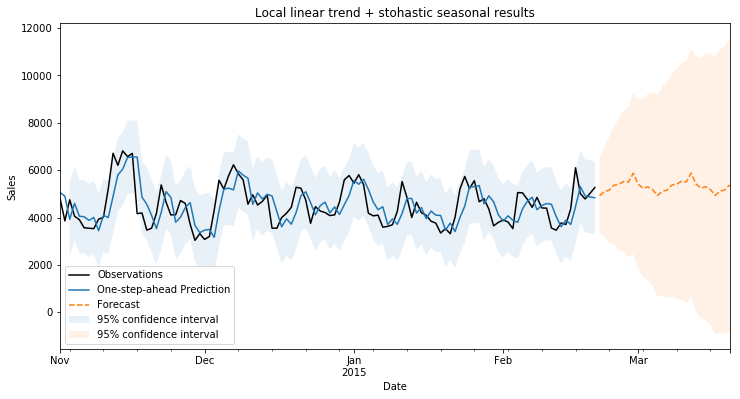

In [64]:
plot(res_model_11, 'Local linear trend + stohastic seasonal')

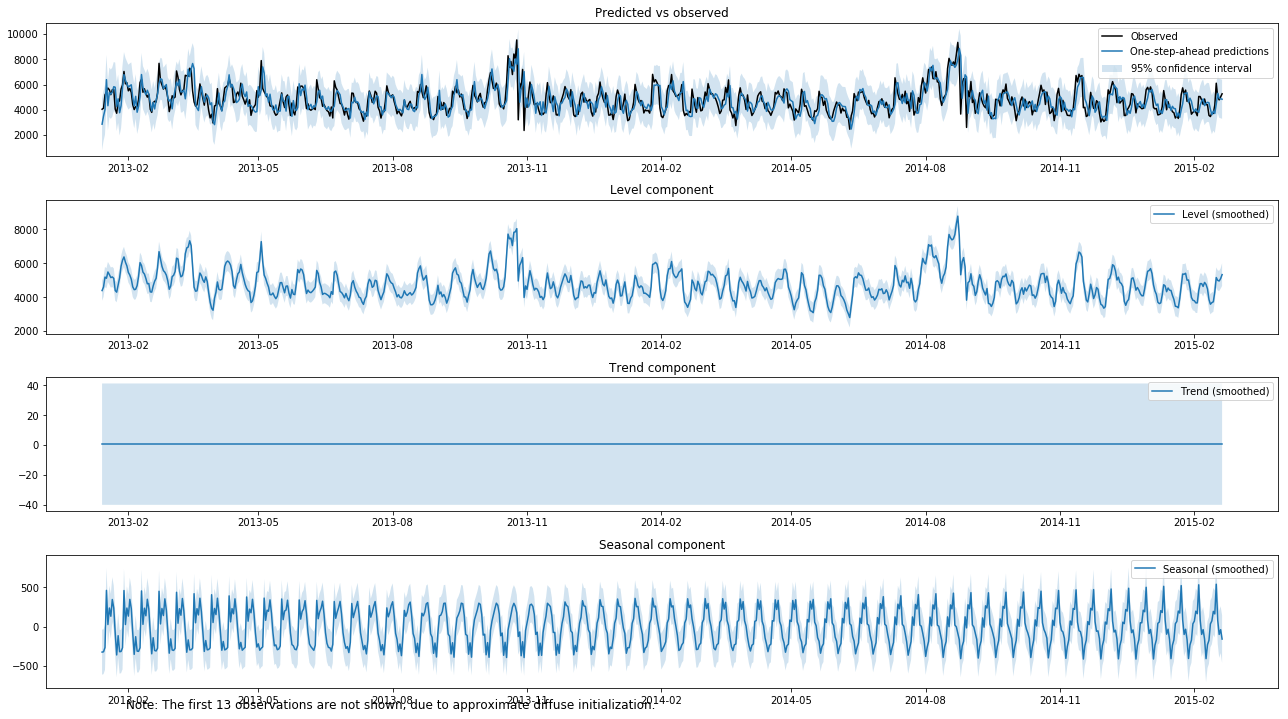

In [65]:
res_model_11.plot_components(figsize=(18, 10))
plt.tight_layout()

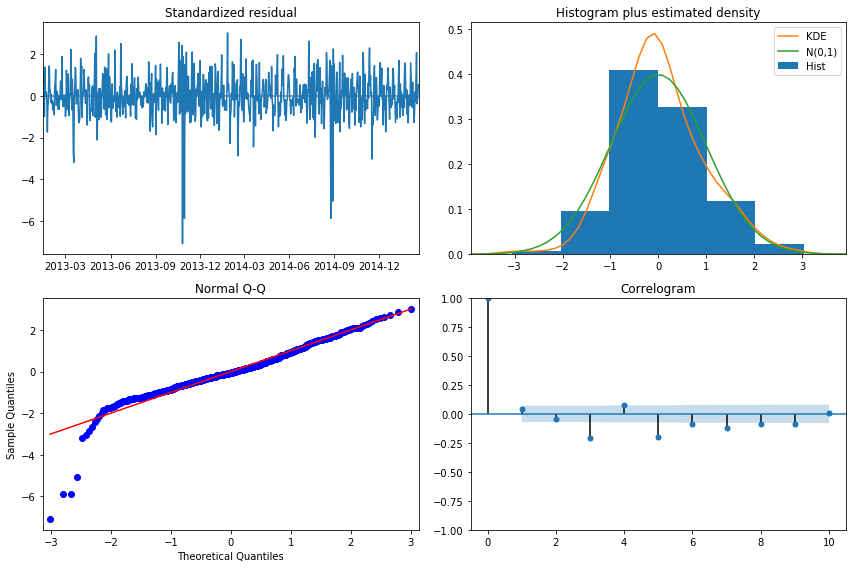

In [66]:
res_model_11.plot_diagnostics(figsize=(12,8))
plt.tight_layout()

## Model 12: local linear trend + seasonal + regressor

Предыдущую версию модели можно уточнить, добавив наблюдаемый объясняющие переменные, или регрессоры. Добавив их в уравнение, связывающее наблюдения с ненаблюдаемыми компонентами, получим статическую регрессию (как в данном случае), а при добавлении регрессора в одно из уравнений ненаблюдаемой компоненты – динамическую. Например, если определить $\mu_t$ как $\mu_t = \mu_{t-1} + \beta_{t-1} + \delta^T x_t + \eta_t$, то получим, что $\mu_{t+1}$ зависит от $\mu_t$, которая в свою очередь зависит от $x_t$. Эти рассуждения верны и для $t+2, t+3, ...$. Таким образом, регрессор, относящийся к моменту времени $t$ влияет на настоящее и будущее значение $\mu$, а следовательно, и на все соответсвующие значения $y_t$.

Но рассмотрим статическую регрессию, которая записывается следующим образом:

$$y_t = \mu_t + \gamma_t + \delta^T x_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$

$$\mu_t = \mu_{t-1} + \beta_{t-1} + \eta_t, \eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$$

$$\beta_t = \beta_{t-1} + \zeta_t, \zeta_t \sim \mathcal{N}(0, \sigma_\zeta^2)$$

$$ \mu_1 \sim \mathcal{N}(a_1, P_1) $$

$$\gamma_t = - \sum_{j=1}^{s-1} \gamma_{t+1-j} + \omega_t, \omega_t \sim \mathcal{N}(0, \sigma_\omega^2)$$

Значения $x_t$ положим равными единице, если день $t$ – воскресенье, и нулю иначе.

In [67]:
df['isSunday'] = (df.DayOfWeek==7).astype('int')
sd_dta = df[df.Store==1][['Sales', 'isSunday']].sort_index()
sd_dta.head(15)

Sales  isSunday
Date                       
2013-01-01      0         0
2013-01-02   5530         0
2013-01-03   4327         0
2013-01-04   4486         0
2013-01-05   4997         0
2013-01-06      0         1
2013-01-07   7176         0
2013-01-08   5580         0
2013-01-09   5471         0
2013-01-10   4892         0
2013-01-11   4881         0
2013-01-12   4952         0
2013-01-13      0         1
2013-01-14   4717         0
2013-01-15   3900         0

In [68]:
model_12 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=sd_dta['Sales'], level='lltrend',
                                                                   trend=True, seasonal=12,
                                                                   cycle=False, autoregressive=None,
                                                                   exog=sd_dta['isSunday'], irregular=True,
                                                                   stohastic_level=True,
                                                                   stohastic_trend=True,
                                                                   stohastic_seasonal=True,
                                                                   stohastic_cycle=False,
                                                                   damped_cycle=False,
                                                                   cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)
/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [69]:
res_model_12 = model_12.fit()
res_model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                         Sales   No. Observations:                  942
Model:                    local linear trend   Log Likelihood               -7932.534
                   + stochastic seasonal(12)   AIC                          15875.068
Date:                       Thu, 22 Jun 2017   BIC                          15899.308
Time:                               11:21:19   HQIC                         15884.308
Sample:                           01-01-2013                                         
                                - 07-31-2015                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   1.35e+06   3.61e+04     37.383      0.000    1.28e+06    1.42e+06
sigma2.level      7071.6746   2479.440      2.852      0.004    2212.061    1.19e+04
sigma2.trend      6.678e-11      0.217   3.08e-10      1.000      -0.425       0.425
sigma2.seasonal   8.666e-05    401.585   2.16e-07      1.000    -787.092     787.092
beta.isSunday    -4591.5993    214.062    -21.450      0.000   -5011.153   -4172.045
===================================================================================
Ljung-Box (Q):                      315.03   Jarque-Bera (JB):              1691.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -1.51
Prob(H) (two-sided):                  0.06   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

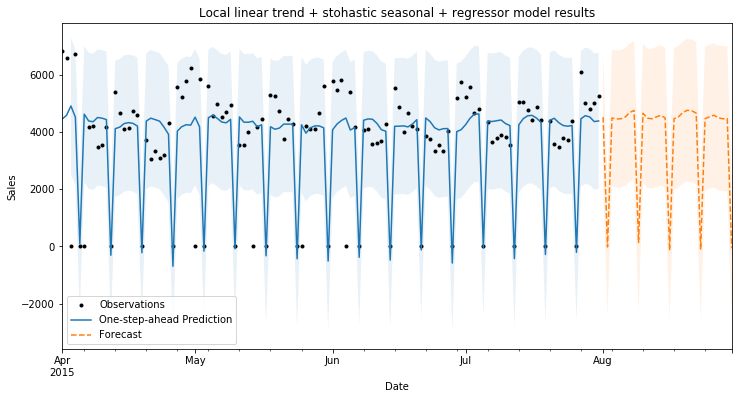

In [70]:
sundays = [0] + [1] + [0]*6 + [1] + [0]*6 + [1] + [0]*6 + [1] + [0]*6 + [1]
sundays = np.asarray(sundays).reshape(30,1)

predict = res_model_12.get_prediction(start='2015-04-01', end='2015-07-31', exog=sd_dta['isSunday'])
forecast = res_model_12.get_forecast('2015-08-30', exog=sundays)

fig, ax = plt.subplots(figsize=(12,6))

sd_dta.ix['2015-04-01':]['Sales'].plot(ax=ax, style='k.', label='Observations')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')

predict_ci = predict.conf_int(alpha=0.05)
ax.fill_between(predict_ci.index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='--', label='Forecast')
forecast_ci = forecast.conf_int()
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='lower left')
ax.set_ylabel('Sales')
ax.set_title('Local linear trend + stohastic seasonal + regressor model results')

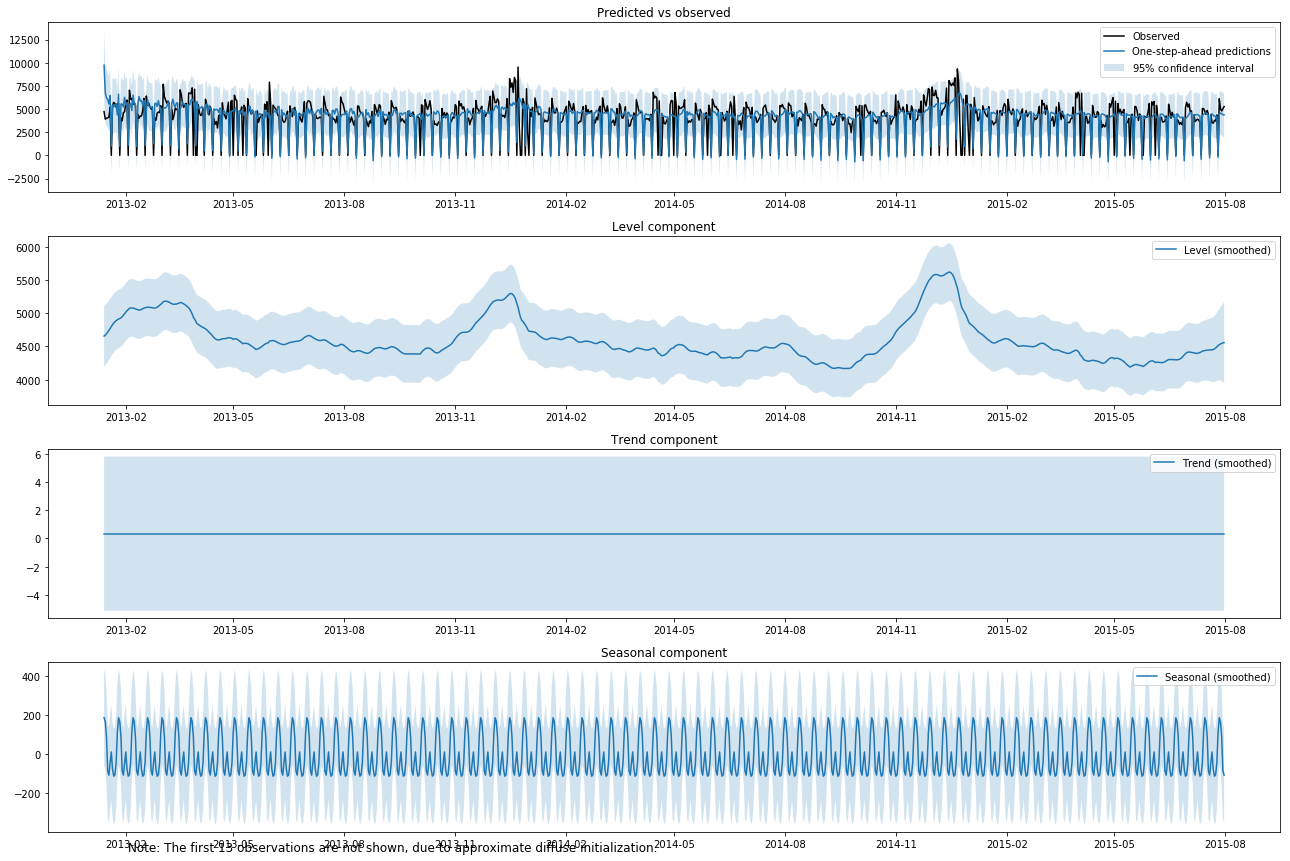

In [71]:
res_model_12.plot_components(figsize=(18, 12))
plt.tight_layout()

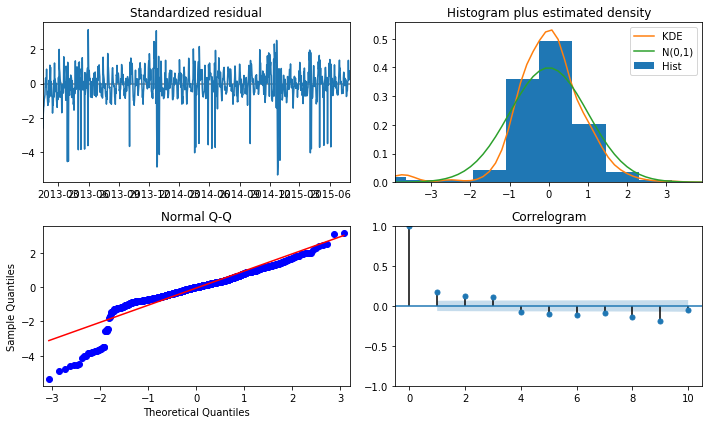

In [72]:
res_model_12.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()

Добавим ещё один регрессор ($z_t$), позволяющий учесть праздничные дни. В таком случае модель записывается так:

$$y_t = \mu_t + \gamma_t + \delta_1^T x_t + \delta_2^T z_t + \varepsilon_t, \varepsilon_t \sim \mathcal{N}(0, \sigma^2_\varepsilon)$$

$$\mu_t = \mu_{t-1} + \beta_{t-1} + \eta_t, \eta_t \sim \mathcal{N}(0, \sigma^2_\eta)$$

$$\beta_t = \beta_{t-1} + \zeta_t, \zeta_t \sim \mathcal{N}(0, \sigma_\zeta^2)$$


In [73]:
df['isSunday'] = (df.DayOfWeek==7).astype('int')
df['isHoliday'] = (df['StateHoliday']=='a').astype('int')
sd_dta = df[df.Store==1][['Sales', 'isSunday', 
                          'isHoliday']].sort_index()
sd_dta.head(10)

Sales  isSunday  isHoliday
Date                                  
2013-01-01      0         0          1
2013-01-02   5530         0          0
2013-01-03   4327         0          0
2013-01-04   4486         0          0
2013-01-05   4997         0          0
2013-01-06      0         1          0
2013-01-07   7176         0          0
2013-01-08   5580         0          0
2013-01-09   5471         0          0
2013-01-10   4892         0          0

In [74]:
model_12_1 = statsmodels.tsa.statespace.structural.UnobservedComponents(endog=sd_dta['Sales'], level='lltrend', 
                                                                        trend=True, seasonal=12, cycle=False, 
                                                                        autoregressive=None,
                                                                        exog=sd_dta[['isSunday', 'isHoliday']], 
                                                                        irregular=True, stohastic_level=True, 
                                                                        stohastic_trend=True,
                                                                        stohastic_seasonal=True,
                                                                        stohastic_cycle=False, damped_cycle=False,
                                                                        cycle_period_bounds=None)

/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)
/Users/ola/anaconda/lib/python3.5/site-packages/statsmodels/tsa/statespace/structural.py:342: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  % attribute, SpecificationWarning)


In [75]:
res_model_12_1 = model_12_1.fit()
res_model_12_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                         Sales   No. Observations:                  942
Model:                    local linear trend   Log Likelihood               -7752.072
                   + stochastic seasonal(12)   AIC                          15516.143
Date:                       Thu, 22 Jun 2017   BIC                          15545.231
Time:                               11:21:25   HQIC                         15527.231
Sample:                           01-01-2013                                         
                                - 07-31-2015                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  5.563e+05    1.8e+04     30.927      0.000    5.21e+05    5.92e+05
sigma2.level       1.89e+05   1.45e+04     13.061      0.000    1.61e+05    2.17e+05
sigma2.trend      7.912e-05     16.657   4.75e-06      1.000     -32.647      32.647
sigma2.seasonal      0.0112    154.000    7.3e-05      1.000    -301.824     301.847
beta.isSunday    -4768.0675     89.160    -53.478      0.000   -4942.818   -4593.317
beta.isHoliday   -5030.5318    312.997    -16.072      0.000   -5643.994   -4417.070
===================================================================================
Ljung-Box (Q):                      277.37   Jarque-Bera (JB):              3951.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

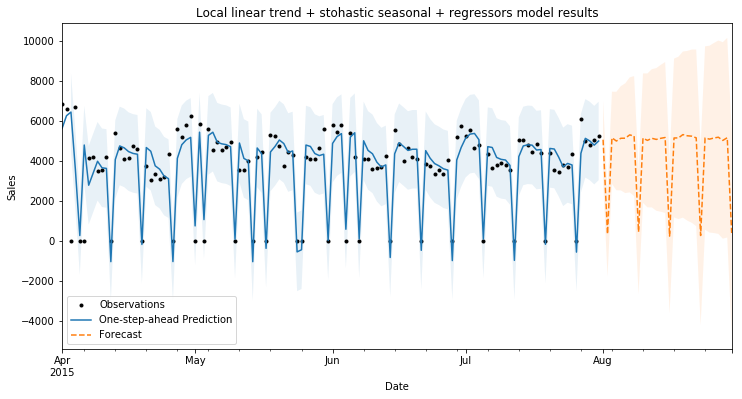

In [76]:
ex = np.asarray([0] + [1] + [0]*6 + [1] + [0]*6 + [1] + [0]*6 + [1] + [0]*6 + [1] + [0]*30).reshape(2,30).T

predict = res_model_12_1.get_prediction(start='2015-04-01', end='2015-07-31', exog=sd_dta[['isSunday', 'isHoliday']])
forecast = res_model_12_1.get_forecast('2015-08-30', exog=ex)

fig, ax = plt.subplots(figsize=(12,6))

sd_dta.ix['2015-04-01':]['Sales'].plot(ax=ax, style='k.', label='Observations')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')

predict_ci = predict.conf_int(alpha=0.05)
ax.fill_between(predict_ci.index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='--', label='Forecast')
forecast_ci = forecast.conf_int()
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], alpha=0.1)

# Cleanup the image
legend = ax.legend(loc='lower left')
ax.set_ylabel('Sales')
ax.set_title('Local linear trend + stohastic seasonal + regressors model results')

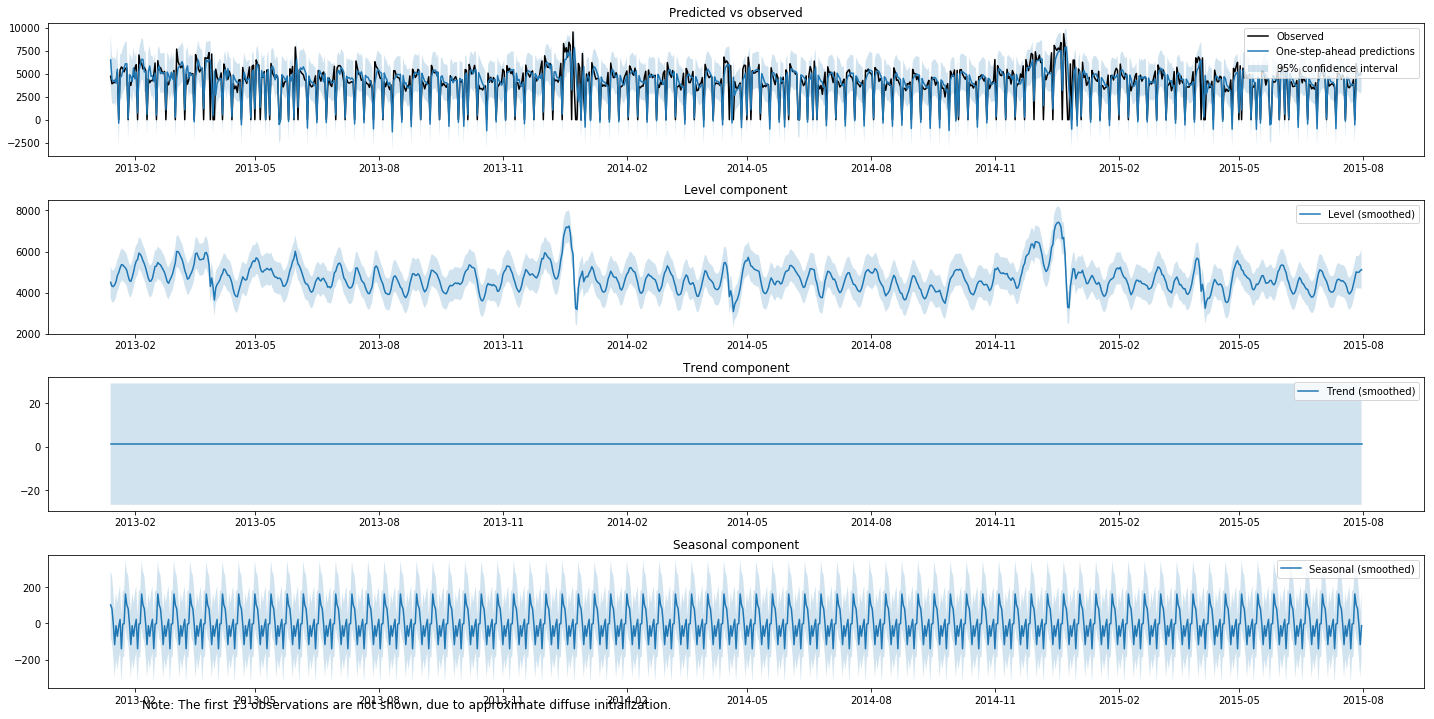

In [77]:
res_model_12_1.plot_components(figsize=(20, 10))
plt.tight_layout()

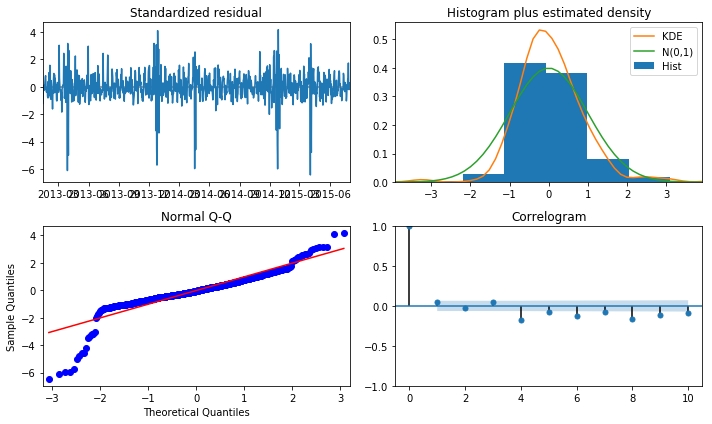

In [78]:
res_model_12_1.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()